### Function API

- Object Classification by Single Sigmoid activation
- Modify Anchor Assignment
  - Every Object should have at least 1 positive anchor
- Fix Focal loss alpha
  - For Recall boost, Weight to Maximum Positive anchor loss
  - fix alpha
- Modify Backbone : Resnet-18
  - Add Activation function
- Data Augmentation by split 2x2
- Data Augmentation by zoom in&out

#### Drawback

- Do not use data which not have any object
- Only 1 batch works
  - TFLite can't not use tf.shape() function, so can not separate batch data
  - if not use TFLite, multi batch ok

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [2]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.0', True)

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [4]:
padded_image_shape = (1024, 1920)
anchor_k = 9
num_classes = 80#
max_data_m = 5000
use_zoom_up_data = False
level_start = 3
level_end = 8
l1 = 1e-10
activation = 'relu'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
class_names = ['bg', 'human','car', 'cat']
path_csv = '/home/sogangori/Downloads/200811_csv.csv'
folder_image = '/home/sogangori/Downloads/water/'
folder_weather = '/home/sogangori/Downloads/weather/'
path_weight = "retinanet/water"

In [5]:
visdrone_categories = ['bg','pedestrian', 'person', 'car', 'van', 'bus', 'truck', 'motor', 'bicycle', 'awning-tricycle', 'tricycle','empty_0','empty_1']
path_visDrone = '/home/sogangori/Downloads/VisDrone2019/VisDrone2019-DET-train/'
path_visDrone_annotation = path_visDrone + 'annotations/'
path_visDrone_image = path_visDrone + 'images/'
os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)
folder_water_image = '/home/sogangori/Downloads/water/'
os.path.isdir(folder_water_image)

human_only = True

In [6]:
def load_visdrone_data(path_visDrone, human_only=True):
    
    list_image_arr = []
    list_cbbox = []
    path_visDrone_annotation = path_visDrone + 'annotations/'
    path_visDrone_image = path_visDrone + 'images/'
    os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)
    list_annotation = glob(path_visDrone_annotation+'*.*')
    list_image_path = glob(path_visDrone_image+'*.*')
    len(list_annotation), len(list_image_path), list_annotation[0]
    
    for i in range(len(list_annotation)):
        path_annotation = list_annotation[i]
        
        df = pd.read_csv(path_annotation, header=None)
        
        bbox_xywh = np.array(df.iloc[:, :4])
        cls = np.array(df.iloc[:, 5])
        x0 = bbox_xywh[:, 0]
        y0 = bbox_xywh[:, 1]
        w = bbox_xywh[:, 2]
        h = bbox_xywh[:, 3]
        x1 = x0 + w
        y1 = y0 + h
                
        human_mask = np.logical_and(cls > 0, cls < 3)
        vehicle_mask = cls > 2
        is_human_contain = np.any(human_mask)
        human_count = np.count_nonzero(human_mask)
        if (human_only and not is_human_contain) or human_count < 8:
            continue
            
        if True:
            margin = 2
            x0 -= margin
            y0 -= margin
            x1 += margin
            y1 += margin
        
        file_name_annotation = path_annotation.split('/')[-1].split('.')[0]
        file_name_image = path_visDrone_image+file_name_annotation+'.jpg'
        img = Image.open(file_name_image)
        img_arr = np.array(img)
        img_h, img_w, img_c = img_arr.shape
        cbbox_norm = np.stack((cls, x0/img_w, y0/img_h, x1/img_w, y1/img_h), axis=1)
        
        cls = np.where(human_mask, 1.0, cls)
        cls = np.where(vehicle_mask, 2.0, cls)        #3.0
        cbbox_norm = np.stack((cls, x0/img_w, y0/img_h, x1/img_w, y1/img_h), axis=1)
        cbbox_norm = cbbox_norm[cls>0]
            
        list_image_arr.append(img_arr)
        list_cbbox.append(cbbox_norm)
        if i%100==0:
            print(len(list_annotation), i, len(list_image_arr), file_name_annotation, img_arr.shape)
        if len(list_image_arr) >= max_data_m: 
            break
    return list_image_arr, list_cbbox

In [7]:
list_visdrone_image_arr, list_visdrone_cbbox = load_visdrone_data(path_visDrone, human_only=human_only)
print(len(list_visdrone_image_arr))

6471 0 1 9999966_00000_d_0000055 (1050, 1400, 3)
6471 200 110 9999998_00074_d_0000059 (1500, 2000, 3)
6471 300 167 9999942_00000_d_0000197 (1050, 1400, 3)
6471 400 221 9999940_00000_d_0000085 (788, 1400, 3)
6471 500 275 0000037_01494_d_0000052 (540, 960, 3)
6471 600 330 0000170_00401_d_0000001 (540, 960, 3)
6471 1000 557 9999955_00000_d_0000020 (788, 1400, 3)
6471 1300 718 0000197_01661_d_0000150 (1080, 1920, 3)
6471 1400 771 9999955_00000_d_0000427 (788, 1400, 3)
6471 1500 827 9999953_00000_d_0000162 (788, 1400, 3)
6471 1600 881 9999987_00000_d_0000033 (1050, 1400, 3)
6471 1700 943 9999981_00000_d_0000139 (1050, 1400, 3)
6471 1800 992 9999984_00000_d_0000153 (1050, 1400, 3)
6471 1900 1044 9999998_00147_d_0000123 (1500, 2000, 3)
6471 2000 1103 0000323_02401_d_0000644 (765, 1360, 3)
6471 2100 1155 9999942_00000_d_0000038 (1050, 1400, 3)
6471 2300 1265 9999969_00000_d_0000045 (1050, 1400, 3)
6471 2400 1323 0000313_01601_d_0000444 (765, 1360, 3)
6471 2500 1368 9999945_00000_d_0000142 (105

display_data(list_visdrone_image_arr, list_visdrone_cbbox, stride=100)

[1. 2.]


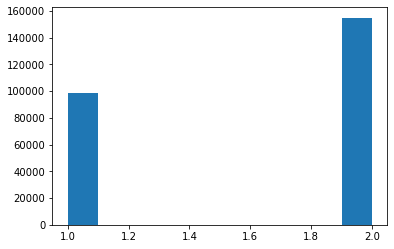

In [8]:
visdrone_cbbox = np.concatenate(list_visdrone_cbbox, 0)
visdrone_cbbox.shape
print(np.unique(visdrone_cbbox[:, 0]))
h = plt.hist(visdrone_cbbox[:, 0])

In [9]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect

True

In [10]:
img_paths = glob(folder_water_image + '*.*')
len(img_paths)

96

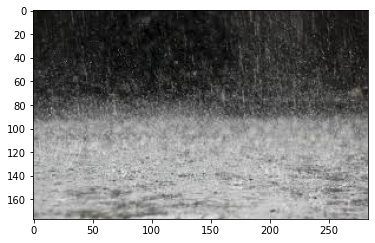

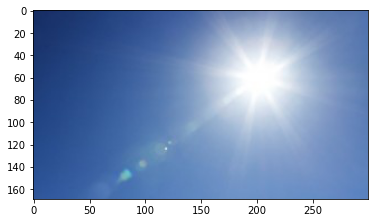

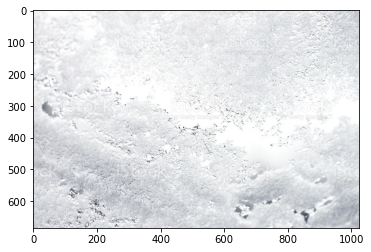

In [11]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()

In [12]:
df = pd.read_csv(path_csv)
df.shape

(265, 7)

In [13]:
df.head()

filename  file_size file_attributes  region_count  region_id  \
0  0001.png    3767995              {}             6          0   
1  0001.png    3767995              {}             6          1   
2  0001.png    3767995              {}             6          2   
3  0001.png    3767995              {}             6          3   
4  0001.png    3767995              {}             6          4   

                             region_shape_attributes region_attributes  
0  {"name":"rect","x":1580,"y":783,"width":52,"he...      {"human":""}  
1  {"name":"rect","x":1865,"y":705,"width":28,"he...      {"human":""}  
2  {"name":"rect","x":1823,"y":678,"width":30,"he...      {"human":""}  
3  {"name":"rect","x":1689,"y":579,"width":21,"he...      {"human":""}  
4  {"name":"rect","x":1349,"y":375,"width":13,"he...      {"human":""}

In [14]:
df['filename'].nunique()

94

In [15]:
annotation = dict()
for i in range(len(df)):
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
    box_map = ast.literal_eval(box)
    region_map = ast.literal_eval(region_attributes)
    #print(i, df.loc[i, 'filename'], box_map)
    if len(box_map.keys())<1:
        print(i, 'no_keys_skip', filename)
        continue
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
    x1 = x0 + width
    y1 = y0 + height
    if True:
        margin = 6
        #print('margin', width, margin)
        x0 -= margin
        y0 -= margin
        x1 += margin
        y1 += margin
    cls_name = list(region_map.keys())[0]
    cls_num = class_names.index(cls_name)
    
    bbox = [cls_num, x0, y0, x1, y1]
    
    if region_id > 0:
        annotation[filename].extend(bbox)
    else:
        annotation[filename] = bbox
        
    #print(i, df.loc[i, 'filename'], width, height)

207 no_keys_skip 0098.png
208 no_keys_skip 0099.png
209 no_keys_skip 0100.png
210 no_keys_skip 0101.png


In [16]:
input_list = []
bbox_list = []
for key in annotation:
    cls_bbox = annotation[key]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
        
    path_image = folder_image + key
    img = Image.open(path_image)    
    scale = np.array((img.width, img.height, img.width, img.height))
    scale = np.reshape(scale, (1, 4))
    #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
    img_arr = np.array(img)        
    bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
    cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)
    
    input_list.append(img_arr)
    bbox_list.append(cls_bbox_norm)

print(len(input_list), len(bbox_list))

90 90


In [17]:
input_list[0].shape, 128*8

((1080, 1920, 3), 1024)

(261, 5)


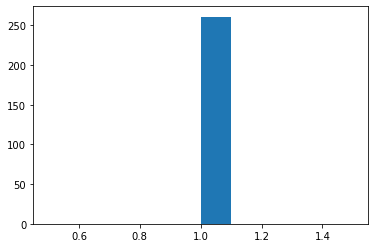

In [18]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0])

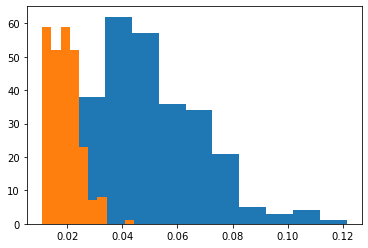

In [19]:
box_w = cbbox[:, -2] - cbbox[:, -4]
box_h = cbbox[:, -1] - cbbox[:, -3]
h = plt.hist(box_h)
h = plt.hist(box_w)

In [20]:
cbbox.shape

(261, 5)

In [21]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        score_txt = class_names[int(cls)]
        ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

In [22]:
def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [23]:
def tile_object(X, BBOX, scope=0.5):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            cy = np.mean((box_y_min + box_y_max)/2)
            cx = np.mean((box_x_min + box_x_max)/2)
            if cy < scope:
                ty0 = np.maximum(0, cy - scope/2)
                ty1 = ty0 + scope
            else:
                ty1 = np.minimum(1.0, cy + scope/2)
                ty0 = ty1 - scope
            if cx < 0.5:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            else:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
            
            #tbox = np.stack((cls, (y0 - ty0)*2, (x0 - tx0)*2, (y1 - ty0)*2, (x1 - tx0)*2), axis=1)
            tbox = np.stack((cls, (x0 - tx0)/scope, (y0 - ty0)/scope, (x1 - tx0)/scope, (y1 - ty0)/scope), axis=1)
            img_y0 = int(ty0 * img_h)
            img_y1 = img_y0 + int(img_h*scope)
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[img_y0:img_y1, img_x0:img_x1]
            crop_xs.append(timg)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [24]:
def attach_tiled_data(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        attach_xs.append(np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        cls, x0, y0, x1, y1 = np.split(bbox, 5, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((cls, x0, y0, x1, y1), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [25]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        #box = box_swap_xy(bbox[:, 1:])
        box = bbox[:, 1:]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
        #box_trans = box_swap_xy(box_trans)
        
        if np.min(box_trans)<0 or np.max(box_trans)>1:
            continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)
    return rotate_xs, rotate_bboxs        

In [26]:
m = len(input_list)
print('m', m)
m = m - m%2
input_list = input_list[:m]
bbox_list = bbox_list[:m]
input_list_train = input_list[::2]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::2]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 90
bbox_list_train 90 45 45


In [27]:
crop_xs, crop_bboxs = tile_object(input_list_train, bbox_list_train)
print('crop_xs', len(crop_xs), len(crop_bboxs))
#display_data(crop_xs, crop_bboxs, stride=10)

crop_xs 44 44


In [28]:
rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=1.5)
rotate_xs_1, rotate_bboxs_1 = gen_rotate_data(crop_xs, crop_bboxs, angle=-1.5)
rotate_xs_2, rotate_bboxs_2 = gen_rotate_data(crop_xs, crop_bboxs, angle=3)
rotate_xs_3, rotate_bboxs_3 = gen_rotate_data(crop_xs, crop_bboxs, angle=-3)
print('rotate_xs', len(rotate_xs), len(rotate_bboxs))

rotate_xs 43 43


In [29]:
crop_xs.extend(rotate_xs)
crop_bboxs.extend(rotate_bboxs)
crop_xs.extend(rotate_xs_1)
crop_bboxs.extend(rotate_bboxs_1)
crop_xs.extend(rotate_xs_2)
crop_bboxs.extend(rotate_bboxs_2)
crop_xs.extend(rotate_xs_3)
crop_bboxs.extend(rotate_bboxs_3)
print('crop_xs', len(crop_xs), len(crop_bboxs))

crop_xs 215 215


In [217]:
if use_weather_effect:
    weather_k = len(weather_images)
    print('weather_k', weather_k)
    m = len(crop_xs)
    for i in range(m):
        if np.random.rand() < 0.2:
            crop_x = crop_xs[i]
            h, w, c = crop_x.shape            
            weather_image = weather_images[np.random.randint(weather_k)]
            
            crop_xs[i] = crop_x//2 + np.array(weather_image.resize((w, h)))//2

weather_k 3


In [30]:
attach_xs, attach_bboxs = attach_tiled_data(crop_xs, crop_bboxs, row=3, col=3)
attach_xs22, attach_bboxs22 = attach_tiled_data(crop_xs, crop_bboxs, row=2, col=2)
attach_xs.extend(attach_xs22)
attach_bboxs.extend(attach_bboxs22)
print('attach_xs', len(attach_xs), len(attach_bboxs), len(attach_xs22))

attach_xs 78 78 54


display_data(rotate_xs_, rotate_bboxs_, stride=10)

display_data(attach_xs, attach_bboxs, stride=2)

display_data(crop_xs, crop_bboxs, stride=10)

display_data(input_list, bbox_list, stride=10)

In [24]:
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 45 215 24


In [31]:
use_zoom_up_data

False

In [32]:
stride = len(input_list_train) // len(attach_xs)
stride = max(1, stride)
for i in range(len(attach_xs)):
    input_list_train.insert(i*stride, attach_xs[i])
    bbox_list_train.insert(i*stride, attach_bboxs[i])
if use_zoom_up_data:
    for i in range(len(crop_xs)):
        input_list_train.insert(1+i*stride, crop_xs[i])
        bbox_list_train.insert(1+i*stride, crop_bboxs[i])    
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

len 123 215 78


In [33]:
input_list_train.extend(list_visdrone_image_arr)
bbox_list_train.extend(list_visdrone_cbbox)
print('len', len(input_list_train), len(input_list_test))

len 3684 45


input_list_train.extend(list_visdrone_image_arr)
input_list_test.extend(list_visdrone_image_arr)
bbox_list_train.extend(list_visdrone_cbbox)
bbox_list_test.extend(list_visdrone_cbbox)

In [456]:
print('len', len(input_list_train), len(input_list_test))

len 3203 45


0 [1.]


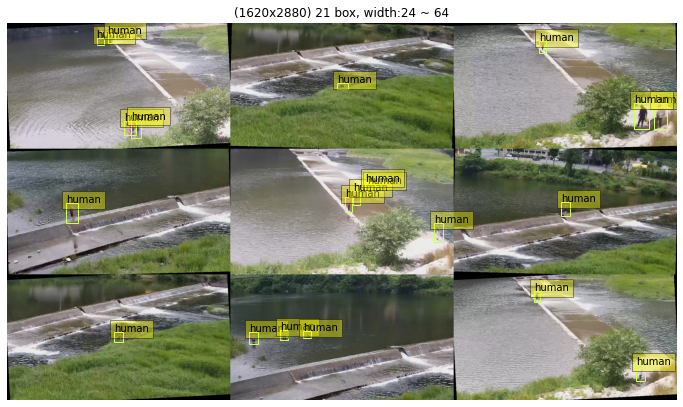

1000 [1. 2.]


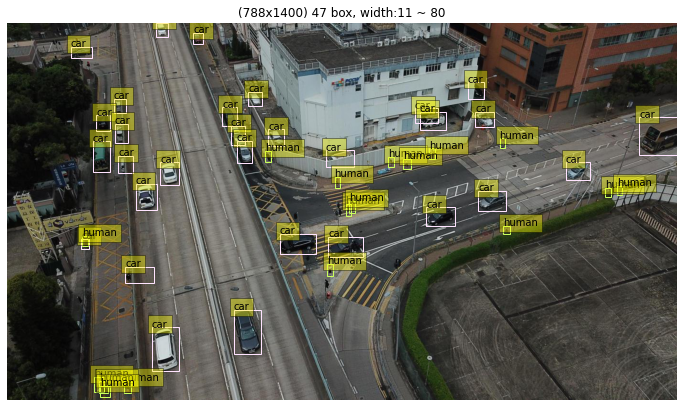

2000 [1. 2.]


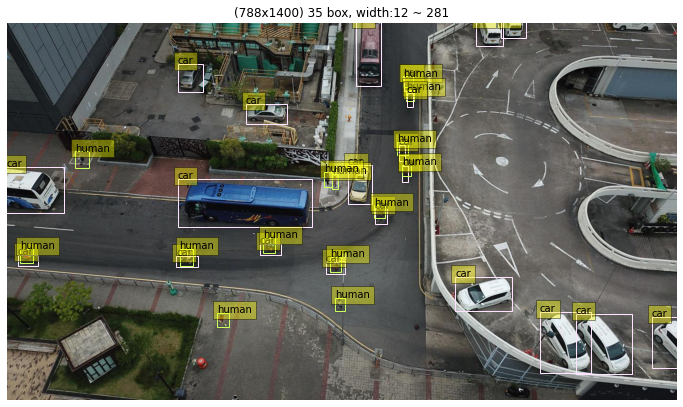

3000 [1. 2.]


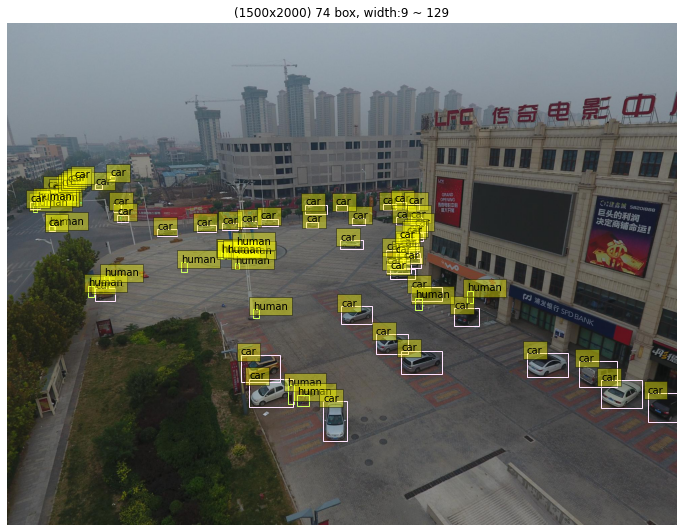

In [34]:
display_data(input_list_train, bbox_list_train, stride=1000)

In [35]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [36]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [37]:
level_start, level_end

(3, 8)

In [38]:
anchor_check = AnchorBox()

In [39]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

(2304, 4) tf.Tensor([124.       124.        71.83757   35.918785], shape=(4,), dtype=float32)
(576, 4) tf.Tensor([120.      120.      143.67514  71.83757], shape=(4,), dtype=float32)
(144, 4) tf.Tensor([112.      112.      287.35028 143.67514], shape=(4,), dtype=float32)
(36, 4) tf.Tensor([ 96.       96.      440.0051  220.00255], shape=(4,), dtype=float32)
(9, 4) tf.Tensor([ 64.       64.      574.70056 287.35028], shape=(4,), dtype=float32)


In [40]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
        
    return image, boxes

def random_flip_vertical(image, boxes):
    is_flipped = tf.zeros_like(boxes[:, 0])
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        boxes = tf.stack([boxes[:, 0], 1 - boxes[:, 3], boxes[:, 2], 1 - boxes[:, 1]], axis=-1)
        is_flipped = tf.ones_like(is_flipped)
        
    return image, boxes, is_flipped


def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    ) 
    
    return image, image_shape, ratio

def resize_and_pad_image_bbox(
    image, bbox, min_side=1024.0, max_side=1024.0*4, jitter=[128*7-32, 128*9-64], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    return image, padded_image_shape, ratio, bbox_padded


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    is_flipped = tf.zeros_like(class_id)
    #image, bbox, is_flipped = random_flip_vertical(image, bbox)    
    is_flipped = tf.cast(is_flipped, tf.int32)
    
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


def preprocess_test_data(image, cls_bbox):         
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    
    image, image_shape, _ = resize_and_pad_image(image)
    is_flipped = tf.zeros_like(class_id)
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


In [41]:
a = tf.cast([[1,2,3,4],[5,6,7,8]], tf.int32)
a0, a1 = tf.split(a, [3,1], -1)
a0, a1

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[4],
        [8]], dtype=int32)>)

In [42]:
def image_color_augment(x):
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < 0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)
    if tf.random.uniform(()) < 0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.sqrt(tf.reduce_mean(x)))
        x += noise
    if tf.random.uniform(()) < 0.2:        
        x = gaussian_filter2d(x, sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)    
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [43]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.3
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)       
        cls_target = tf.expand_dims(cls_target, axis=-1)        
        label = tf.concat([box_target, cls_target], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        #is_flipped 0 or 1
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        cls_ids, is_flipped = tf.split(cls_flip, 2, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        is_flipped = tf.squeeze(is_flipped, -1)
        is_flipped = tf.cast(is_flipped, tf.float32)
                            
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        label = tf.reshape(label, [1, -1, 5], name='label_to_3d')
        is_flipped_anchor = tf.zeros_like(label[:, :, :1]) + tf.reduce_max(is_flipped)
        label = tf.concat((label, is_flipped_anchor), -1)
        return batch_images, label
      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        
        batch_images = image_color_augment(batch_images)#new        
        return self.encode_batch(batch_images, gt_boxes, cls_flip)

In [44]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [45]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)   
    
    if downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out

def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(inputs)
    t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    #num_blocks_list = [2, 2, 2, 2]#resnet-18
    num_blocks_list = [3, 4, 6, 3]#resnet-34
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
        
    return t_list

In [46]:
def featurePyramidNet(c345):    
    #c3_output, c4_output, c5_output = c345
    c3_output = c345[0]
    c4_output = c345[1]
    c5_output = c345[2]
    
    regulizer  = tf.keras.regularizers.L2(l1)
    p3_output = Conv2D(256, 1, 1, "same", activation=activation, kernel_regularizer=regulizer)(c3_output)
    p4_output = Conv2D(256, 1, 1, "same", activation=activation, kernel_regularizer=regulizer)(c4_output)
    p5_output = Conv2D(256, 1, 1, "same", activation=activation, kernel_regularizer=regulizer)(c5_output)
    p5_output_up = keras.layers.UpSampling2D(2)(p5_output)
    p4_output_up = keras.layers.UpSampling2D(2)(p4_output)
    p4_output = keras.layers.Add()([p4_output, p5_output_up])    
    p3_output = keras.layers.Add()([p3_output, p4_output_up])
    
    p3_output = Conv2D(256, 3, 1, "same", activation=activation, kernel_regularizer=regulizer)(p3_output)
    p4_output = Conv2D(256, 3, 1, "same", activation=activation, kernel_regularizer=regulizer)(p4_output)
    p5_output = Conv2D(256, 3, 1, "same", activation=activation, kernel_regularizer=regulizer)(p5_output)
    p6_output = Conv2D(256, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(c5_output)
    p7_output = Conv2D(256, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(p6_output)
    return p3_output, p4_output, p5_output, p6_output, p7_output    

In [47]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

(788, 1400, 3)
(788, 1400, 3)
diff 291675204


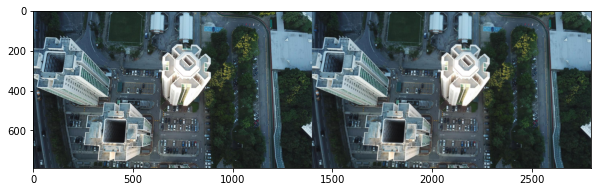

In [48]:
x0 = input_list_train[-1]
print(x0.shape)
x0_1 = gaussian_filter2d(x0, sigma=10)
#x0_1 = sharpness(x0, factor=10)
x0_1 = x0_1.numpy()

print(x0_1.shape)
print('diff', np.sum(np.abs(x0 - x0_1)))
x0_stack = np.concatenate((x0, x0_1), axis=1).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.imshow(x0_stack)

In [49]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    
    inputs = Input(shape=(None, None, 3))        
  
    N = tf.shape(image)[0]# TFLite cannot convert tf.shape() function
    #N = 1
        
    nets_3 = create_resnet_backbone(inputs/255)
    features = featurePyramidNet(nets_3)
    
    cls_outputs = []
    box_outputs = []
   
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    conv_c0 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c1 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c2 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c3 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_c4 = keras.layers.Conv2D(anchor_k * num_classes, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability)   
    
    conv_b0 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b1 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b2 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b3 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)
    conv_b4 = keras.layers.Conv2D(anchor_k * 4, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer="zeros")   
    drop = keras.layers.Dropout(0.1)
    
    cbox_outputs = []
            
    for feature in features:            
        box_out = conv_b4(drop(conv_b3(conv_b2(conv_b1(conv_b0(feature))))))
        cls_out = conv_c4(drop(conv_c3(conv_c2(conv_c1(conv_c0(feature))))))
        
        box_out = tf.reshape(box_out, [N, -1, 4], name='reshape_box_out')
        cls_out = tf.reshape(cls_out, [N, -1, num_classes], name='reshape_cls_out')
        
        cbox_out = tf.concat((box_out, cls_out), axis=-1)#new        
        cbox_outputs.append(cbox_out)
    
    outputs = tf.concat(cbox_outputs, axis=1)    
    outputs = tf.reshape(outputs, [1, -1, 4 + num_classes], name='model_out')
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


In [50]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=100,
                      max_detections=100,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
        
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)    
    anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:-1]
    #cls_predictions = tf.nn.softmax(predictions[:, :, 5:])
    #cls_predictions = tf.round(objectness) * cls_predictions         
    #cls_predictions = objectness
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)        
    return output   

In [51]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes

        
    def call(self, y_cls, y_pred):
        #shape=(None, None),  shape=(None, None, num_class), dtype=float32)
        #alpha:0.25
        real_class_num = 4
        y_cls = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls, depth=self._num_classes, dtype=tf.float32,)
        is_exist_non_human_class = tf.reduce_any(y_cls > 1)
        y_positive = tf.cast(y_cls > 0, tf.float32)          
        objectness = y_pred[:, :, 0] + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
        pt = tf.nn.sigmoid(objectness)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)        
        
        loss_obj = loss_p + loss_f
        pred_positive_cls_prob = tf.nn.softmax(y_pred[:, :, 1:1+real_class_num])
        y_hot_positive = y_hot[:, :, :real_class_num]
        cls_pt = tf.clip_by_value(pred_positive_cls_prob, 1e-7, 1.0 - 1e-7)
        loss_cls = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot_positive * tf.math.log(cls_pt)        
        loss_cls = tf.reduce_sum(loss_cls, axis=-1)        
        loss_cls = tf.cast(is_exist_non_human_class, tf.float32) * y_positive * loss_cls
        loss = 2 * loss_obj + loss_cls
        return loss


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.2, gamma=2.0, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        #self._clf_loss2 = RetinaNetClassificationLoss2(alpha, gamma, num_classes-1)
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes-1)
        self._box_loss = RetinaNetBoxLoss(delta)
      
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        
        y_cls = y_true[:, :, 4]
        cls_predictions = y_pred[:, :, 4:-1]        
        
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)

        #clf_loss2 = self._clf_loss2(y_cls, cls_predictions)
        clf_loss = self._clf_loss(y_cls, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions) 
        
        #clf_loss2 = tf.where(ignore_mask, clf_loss2, clf_loss2)        
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        box_loss = tf.where(positive_mask, box_loss, 0.0)    
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)        
        #clf_loss2 = tf.math.divide_no_nan(tf.reduce_sum(clf_loss2, axis=-1), normalizer)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)        
        loss = clf_loss + box_loss# + clf_loss2
        return loss
 

In [52]:
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_cls_symbol = tf.round(tf.nn.sigmoid(y_pred[:, :, 4]) )    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    h_cls = tf.math.argmax(y_pred[:, :, 5:], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls-1, h_cls), y_positive)    
    return acc


In [53]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [54]:
def generator():
    m = len(input_list_train)
    for i in range(m):
        x = input_list_train[i]
        y_box = bbox_list_train[i]        
        yield (x, y_box)

def generator_test():
    m = len(input_list_test)
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]
        yield (x, y_box)
        
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5]))
    )
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset
np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]    
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (1620, 2880, 3) (21, 5) [1.   0.17 0.26 0.19 0.3 ]


In [55]:
batch_size = 1 # 7 OOM-Warn
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch_train, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)


In [56]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

img (1024, 1664, 3) <class 'numpy.ndarray'> 0 114.75575549785907 255


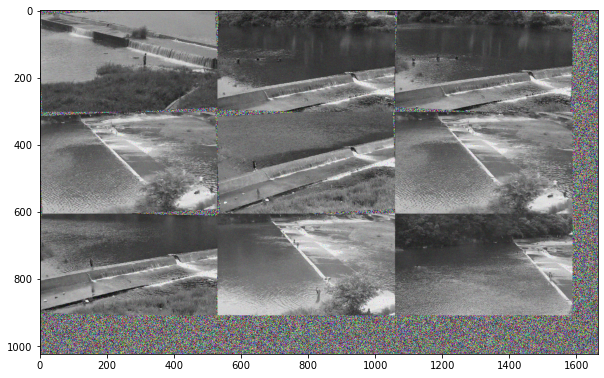

In [57]:
for image, cbbox in train_dataset: 
    img = image[0].numpy().astype(np.uint8)
    print('img', img.shape, type(img), np.min(img), np.mean(img), np.max(img))
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    break
    

In [58]:
np.set_printoptions(linewidth=200)
image_height, image_width = padded_image_shape

anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                       for i in range(level_start, level_end)]
print('anchor_feature_size', anchor_feature_size)
img_check = 0
for image, cbbox in val_dataset:         
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    
    m = len(cbbox)
    
    positive_count = np.sum(cls_gt>0)

    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

anchor_feature_size [(128.0, 240.0), (64.0, 120.0), (32.0, 60.0), (16.0, 30.0), (8.0, 15.0)]
cbbox (1, 368280, 6)
cls_sum 511 367690 79 0
cls_mean 0.0013875312262409036 0.9983979580753775 0.00021451069838166611 0.00021451069838166611
shape (1, 1024, 1920, 3) (1, 368280, 6) unique [-1.  0.  1.]
anchor_feature_size [(128.0, 240.0), (64.0, 120.0), (32.0, 60.0), (16.0, 30.0), (8.0, 15.0)]
cbbox_anchor (1, 128, 240, 9) 437 275968 75 0 ratio 0.0002712673611111111
cbbox_anchor (1, 64, 120, 9) 74 69042 4 0 ratio 5.787037037037037e-05
cbbox_anchor (1, 32, 60, 9) 0 17280 0 0 ratio 0.0
cbbox_anchor (1, 16, 30, 9) 0 4320 0 0 ratio 0.0
cbbox_anchor (1, 8, 15, 9) 0 1080 0 0 ratio 0.0


Text(0.5, 1.0, '(1, 128, 240, 9)0.0002712673611111111 75')

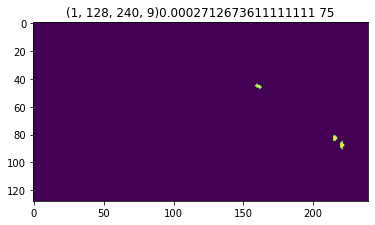

In [59]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [60]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((1920, 1024)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((1920, 1024)))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((1920, 1024)))
pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((1920, 1024)))
pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((1920, 1024)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = pmap3.astype(np.uint8)
pmap4 = pmap4.astype(np.uint8)

Text(0.5, 1.0, '0.0015625')

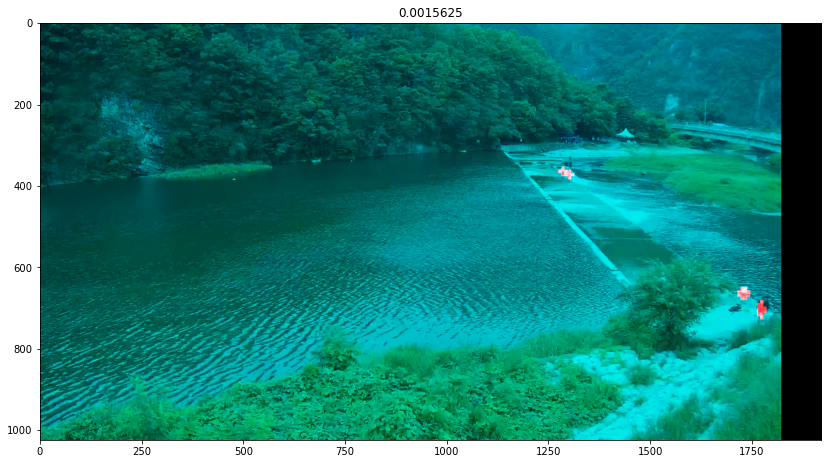

In [61]:
pmap_with_img =  np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [62]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [63]:
#ptimizer = tf.optimizers.SGD(learning_rate=1e-5, clipvalue=5.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-2)#, clipvalue=10.
loss_fn = RetinaNetLoss(num_classes)
model = createRetinaNet(num_classes, anchor_k)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[recall, precision, accuracy])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=100
    )
]

In [64]:
loss_list = []
loss_var_list = []
load_weight()
print(len(input_list_train), len(input_list_test))

latest_checkpoint retinanet/water
3684 45


In [79]:
model.evaluate(val_dataset.take(20))
# current 0.83/0.83
# best color_aug 0.85/0.96, 3s 149~150ms, 158ms/step

20/20 [==============================] - 2s 87ms/step - loss: 6.4136 - recall: 0.0198 - precision: 0.2352 - accuracy: 0.0000e+00


[6.413647651672363, 0.019822681322693825, 0.2351773977279663, 0.0]

In [72]:
epochs = 1
hist = model.fit(
    train_dataset.take(10000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)
#1000/1000  - 247s 247ms/step - loss: 4.1498 - recall: 0.0959 - precision: 0.4927 - accuracy: 0.7286
#3149/3149  - 780s 248ms/step - loss: 4.6285 - recall: 0.1527 - precision: 0.5448 - accuracy: 0.1049
#             805s 256ms/step - loss: 4.5492 - recall: 0.1628 - precision: 0.5541 - accuracy: 0.1046

3684/3684 [==============================] - 927s 252ms/step - loss: 4.5378 - recall: 0.1635 - precision: 0.5527 - accuracy: 0.0964


In [73]:
model.save_weights(path_weight)

In [74]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.1)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [75]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects

def attach_crop_image(image, boxes):
    
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes))
    bbox_k = len(crop_bbox_arr)
    if bbox_k > 0 and bbox_k < 100:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(resize_w, img_w//10)
        footer = np.zeros((resize_h, img_w, img_c), np.uint8)

        for i in range(bbox_k):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            footer[:, i*resize_w:(i+1)*resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image
    
def visualize_detections(
    image, boxes, classes, scores, figsize=(10, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=1
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        score_txt = str.format('%d %.2f' %(cls, score))
        ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [76]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, 1:] * scale
               
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            
            detected_box = inference_model.predict(input_image)        
            print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)
            
            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        i+=1

(1, 1024, 1920, 3) detected_box (2, 6) [[2880 1620 2880 1620]] ratio tf.Tensor(0.6320988, shape=(), dtype=float32)


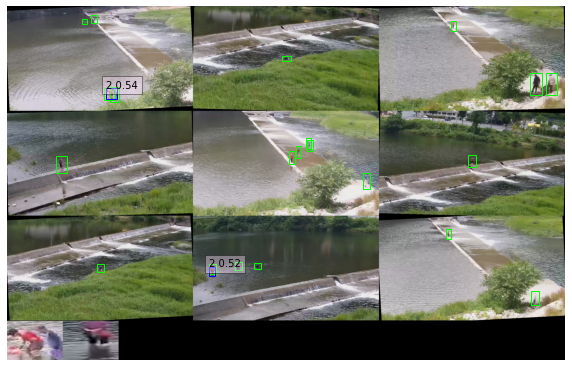

(1, 1024, 1920, 3) detected_box (34, 6) [[1400  788 1400  788]] ratio tf.Tensor(1.2994924, shape=(), dtype=float32)


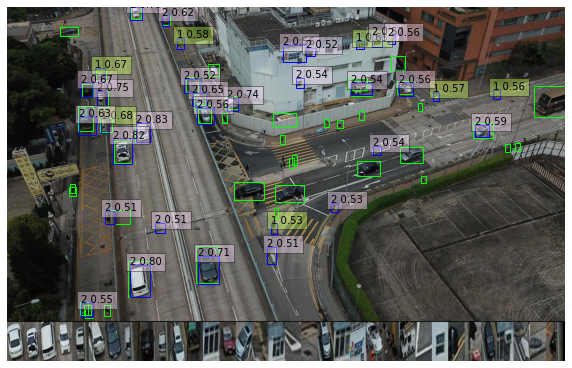

(1, 1024, 1920, 3) detected_box (36, 6) [[1400  788 1400  788]] ratio tf.Tensor(1.2994924, shape=(), dtype=float32)
crop_bbox_image 93 59 crop_image_arr.shape (59, 0, 3)


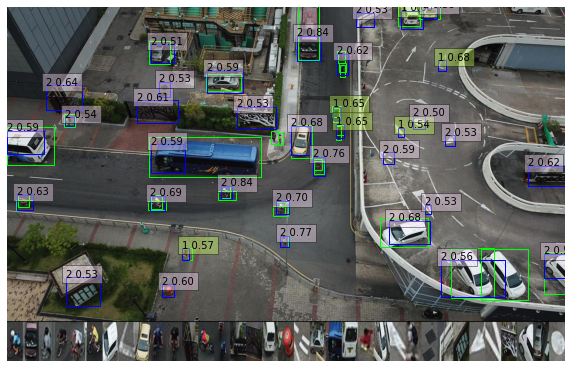

(1, 1024, 1408, 3) detected_box (29, 6) [[2000 1500 2000 1500]] ratio tf.Tensor(0.68266666, shape=(), dtype=float32)


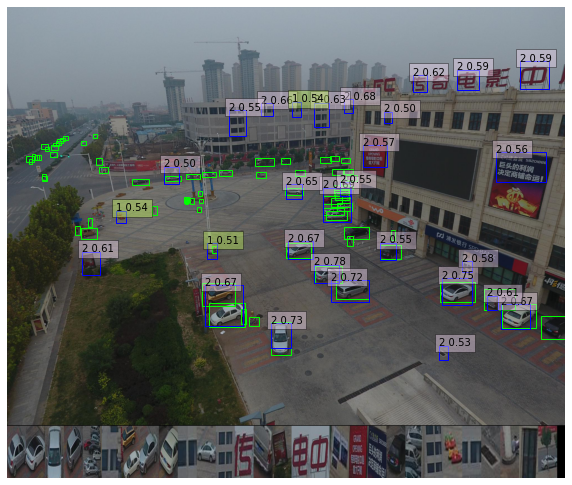

In [77]:
check_test(dataset, bbox_list_train, step=1000)

(1, 1024, 1920, 3) detected_box (2, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)


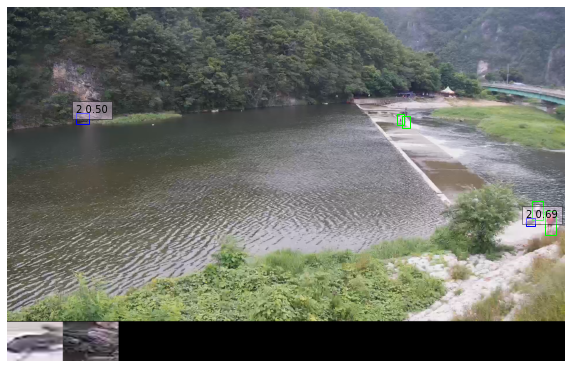

(1, 1024, 1920, 3) detected_box (1, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)


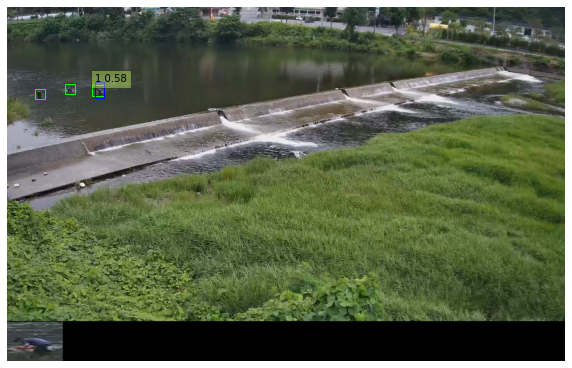

In [78]:
check_test(dataset_test, bbox_list_test, step=30)

## load model from .pb file

In [390]:
saved_model_pb = './water_pb'

In [391]:
inference_model.save(saved_model_pb)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./water_pb/assets


In [394]:
#custom_objects = {'RetinaNetLoss':RetinaNetLoss(num_classes), 'recall':recall,'precision':precision}
custom_objects = {'recall':recall,'precision':precision, 'flip_accuracy':flip_accuracy}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [395]:
model_loaded.compile()

detected_box (6, 6)


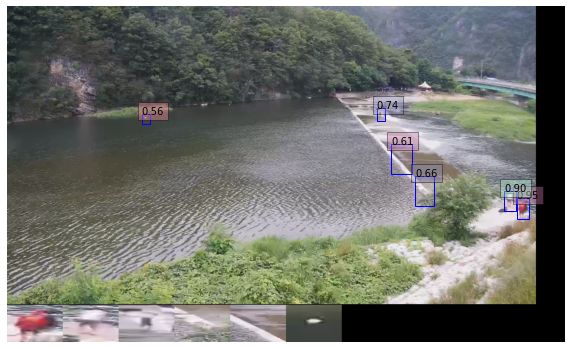

In [397]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_pb)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter

In [ ]:
tflite_model = converter.convert()#tf.CombinedNonMaxSuppression

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_results = interpreter.get_tensor(output_details[0]['index'])

# Test the TensorFlow model on random input data.
tf_results = model(tf.constant(input_data))

# Compare the result.
for tf_result, tflite_result in zip(tf_results, tflite_results):
  np.testing.assert_almost_equal(tf_result, tflite_result, decimal=5)

In [ ]:
input_details

In [ ]:
tf_result.shape, tf_result.shape

In [ ]:
inference_model.save('inference_model.h5')
!ls *.h5

In [ ]:
for var in model.trainable_variables:
    print(var.name, var.shape)